# Physics of Cosmic Structures: week 4 exercises
## Classical Inflation

### II. Horizon Tiling of the Sky

In [1]:
import sys,platform,os

import matplotlib
from matplotlib import pyplot as plt
import numpy as np

#I had to go two directories up to find the CAMB folder (because I am in "Week4" inside "Cosmic_Structures")
_camb_path = os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('.'))), 'CAMB')
sys.path.insert(0,_camb_path)

import camb
print('Using CAMB %s installed at %s' %(camb.__version__,os.path.dirname(camb.__file__)))

Using CAMB 1.5.4 installed at /Users/marigalla/AstroCosmoComputational/Students/MariaLuisaGallavotti/CAMB/camb


## Parameters
* `H0`: the present-day value of the Hubble constant in units of km/s/Mpc.

* `ombh2`: the physical density of baryons multiplied by the square of the Hubble constant, denoted as $\Omega_b h^2$.

* `omch2`: the physical density of cold dark matter (CDM) multiplied by the square of the Hubble constant, denoted as $\Omega_c h^2$.

* `mnu`: the sum of the neutrino masses, typically given in eV.

* `omk`: the curvature parameter of the universe.

* `tau`: the optical depth to reionization.

* `As`: the amplitude of primordial scalar fluctuations, typically represented by AsA_sAs​ or AAA.

* `ns`: the spectral index of primordial scalar fluctuations.

* `halofit_version`: specifies which version of the HALOFIT nonlinear matter power spectrum model to use.

* `lmax`: the maximum value of multipole moment for which to compute the CMB power spectrum.

In [2]:
pars = camb.set_params(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06,  
                       As=2e-9, ns=0.965, halofit_version='mead', lmax=3000)

results = camb.get_results(pars)

### 1. Calculate numerically the angular size of the horizon at a given redshift, projected on the sky, and plot the results.

In order to compute the angular size of the horizon, two distances are necessary:
* the *angular comoving distance to the horizon* $\chi_{angH} (z)$ (`chi_ang_H`), which represents the maximum distance from which light could have traveled to us since the beginning of the Universe up to redshift $z$, divided by $(1+z)$;
* the *angular diameter distance* $D_A(z)$ (`D_A`), which accounts for the apparent size of an object in the sky due to its physical size and the geometry of the Universe.

Indeed, the angular size $\theta_H (z)$ (`theta`) of the horizon at redshift $z$ is given by: $\quad \theta_H (z) = \frac{\chi_{angH} (z)}{D_A (z)}$

> Angular diameter distance

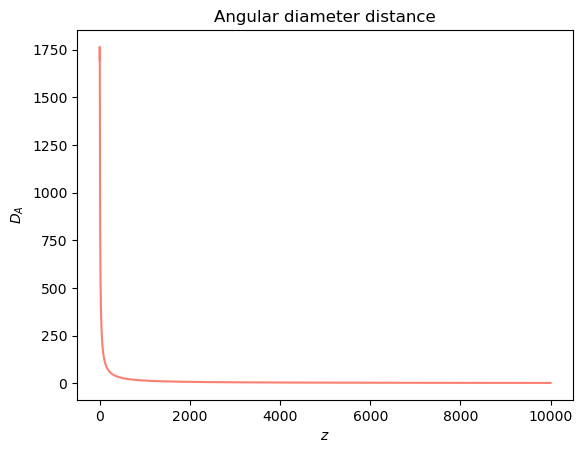

In [3]:
#redshifts
z=np.linspace(1,1e4,10000)

#angular diameter distance
D_A=results.angular_diameter_distance(z)

#plot
plt.figure()
plt.plot(z,D_A,color='salmon')
plt.xlabel('$z$')
plt.ylabel('$D_A$')
plt.title('Angular diameter distance')
plt.show()

> Comoving distance to the horizon

**Observation:**

CAMB's function `comoving_radial_distance(z)` computes the comoving radial distance from the observer at $z=0$ to the redshift $z$, however in this case I am interested in the comoving distance to the horizon, namely from redshift $z$ to $z=∞$, so in order to obtain $\chi_H(z)$ I have to subtract $\chi(z)$ from $\chi(∞)$.

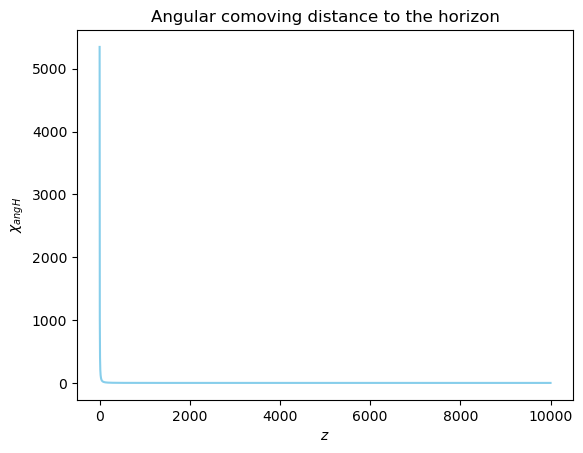

In [4]:
#comoving distance to the horizon
chi=results.comoving_radial_distance(z)
chi_inf=results.comoving_radial_distance(1e9) #I put z=1e9 instead of infinity (putting values greater that 1e9, like 1e10 or even 1e20, gives the same result anyway)
chi_H=chi_inf-chi

#angular comoving distance to the horizon
chi_ang_H=chi_H/(1+z)

#plot
plt.figure()
plt.plot(z,chi_ang_H,color='skyblue')
plt.xlabel('$z$')
plt.ylabel('$\chi_{angH}$')
plt.title('Angular comoving distance to the horizon')
plt.show()

> Angular size of the horizon

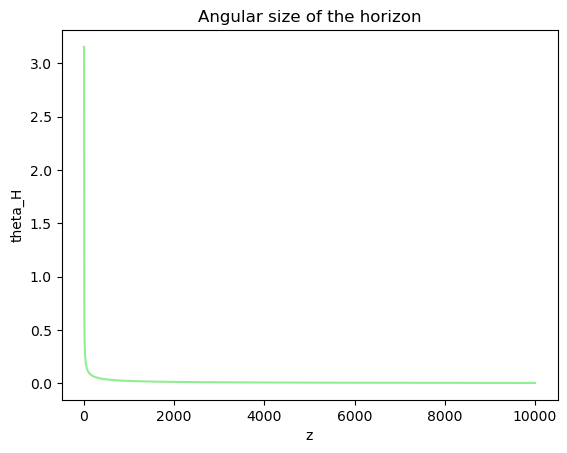

In [5]:
#angular size of the horizon
theta_H=chi_ang_H/D_A

#plot
plt.figure()
plt.plot(z,theta_H,color='lightgreen')
plt.xlabel('z')
plt.ylabel('theta_H')
plt.title('Angular size of the horizon')
plt.show()

Check for the value of $\theta_H$ at the last scattering surface, which corresponds to $z_{LS} \simeq 1100$:

In [6]:
#angular size at z=1100
theta_H_LS=theta_H[np.where(z==1100)][0]
theta_H_LS_deg=theta_H_LS*180/np.pi
print("The angular size of the horizon at z=1100 is %.4f radians, or %.4f degrees" %(theta_H_LS,theta_H_LS_deg))

The angular size of the horizon at z=1100 is 0.0201 radians, or 1.1527 degrees


### 2. How many horizons are needed to fully tile the sky at a given redshift?
In order to answer this question it is necessary to determine the number of horizons that fit into the entire sky area. This value is given by $\ N_{horizons}=\frac{S_{sky}}{S_{horizon}} \ $ (`N_H`), where $S_{sky}$ (`S_s`) and $S_{horizon}$ (`S_H`) are the sky area and the horizon area, respectively.

* The area of the sky, in steradians, is $4 \pi$;
* the area of the horizon corresponds to the solid angle $\Omega$ subtended by a pach of angular size $\theta$: $\ \Omega \simeq \pi \theta ^2$.

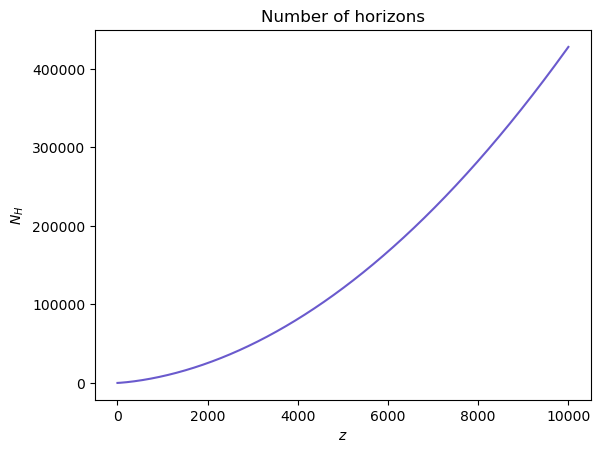

In [7]:
S_s=4*np.pi
S_H=np.pi*theta_H**2
N_H=S_s/S_H

#plot
plt.figure()
plt.plot(z,N_H,color='slateblue')
plt.xlabel('$z$')
plt.ylabel('$N_H$')
plt.title('Number of horizons')
plt.show()

### 3. Define a test statistic on each horizon sized patch, at a given redshift. What is the scaling of the variance of the test statistic at each redshift?

> First of all, I have to define a test statistic and simulate data for multiple horizon sized patches at different redshifts.

**N.B.:** I had to use NumPy's vectorized operations instead of explicit loops in order to improve performance, because it was taking too long to run (more than 10 minutes).

In [8]:
#definition of a function to simulate the test statistic
def simulate_test_statistic_vectorized(N_H, num_simulations=10):
    if N_H < 1:
        N_H = 1
    patches = np.random.normal(0, 1, size=(num_simulations, int(N_H)))
    test_statistic_means = np.mean(patches, axis=1)
    return test_statistic_means

> Then, I have to calculate the variance of the test statistic for each redshift.

In [9]:
#computation of the variances of the test statistic
variances = np.zeros(len(N_H))
for i, n_h in enumerate(N_H):
    test_statistic_means = simulate_test_statistic_vectorized(n_h)
    variances[i] = np.var(test_statistic_means, ddof=1)

> Finally, I have to analyze how the variance scales with the number of patches (or, analogously, with redshift).

* Variance of the test statistic against redshift.

In this step I find how much the values of the test statistic vary as redshift changes. For each redshift, a value for the test statistic is generated, and then the variance of these values is determined.

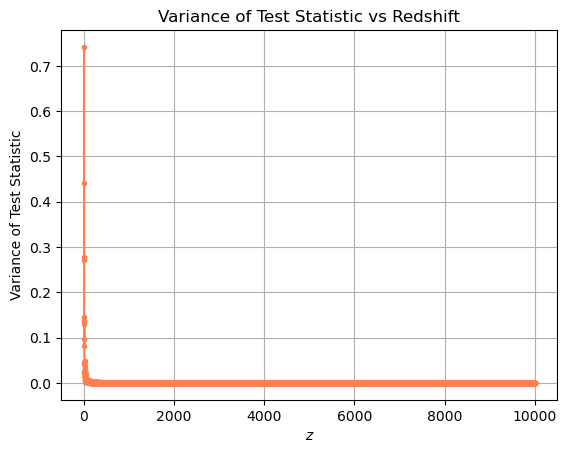

In [17]:
#variance vs redshift
plt.figure()
plt.plot(z, variances, 'o-', color='coral', markersize=3)
plt.xlabel('$z$')
plt.ylabel('Variance of Test Statistic')
plt.title('Variance of Test Statistic vs Redshift')
plt.grid(True)
plt.show()

* Log-log plot to analyze the scaling of variance.

This type of plot is useful because it allows for a better evaluation of the relationship between variance and redshift over a wide range of values.

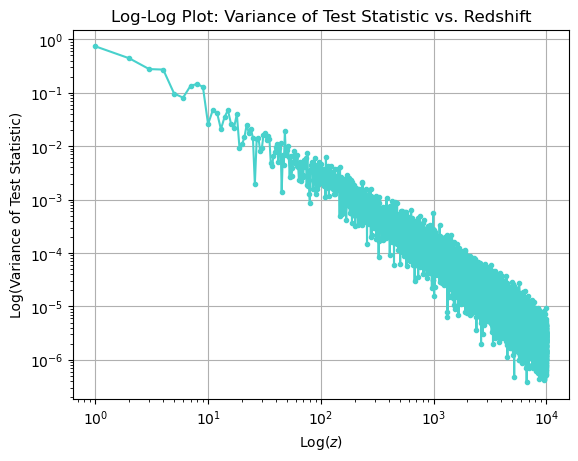

In [18]:
valid_indices = variances > 0  #only positive values
plt.figure()
plt.loglog(z[valid_indices], variances[valid_indices], 'o-', color='mediumturquoise', markersize=3)
plt.xlabel('Log($z$)')
plt.ylabel('Log(Variance of Test Statistic)')
plt.title('Log-Log Plot: Variance of Test Statistic vs. Redshift')
plt.grid(True)
plt.show()

* Fit a line to the log-log plot to determine the scaling exponent.

This final step is helpful to quantify the relationship between variance and redshift. The slope of the line (the scaling exponent $\gamma$) determined through this process signifies how much the variance changes with redshift.

$\log(\sigma^2)\propto \gamma \log(z)$

In [21]:
log_z = np.log(z[valid_indices])
log_variances = np.log(variances[valid_indices])
coeffs = np.polyfit(log_z, log_variances, 1)
scaling_exponent = coeffs[0]
print(f'Scaling Exponent: {scaling_exponent}')

Scaling Exponent: -1.5948458033142394


The negative value of the scaling exponent, $\gamma = -1.5948$, signifies that the variance decreases as redshift increases, following the power-law relationship $\sigma ^2 \propto z^\gamma$.